In [16]:

using Statistics
#using CuArrays
using Random
using Zygote
using Flux, Flux.Optimise
using Metalhead, Images
using Metalhead: trainimgs
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition


In [34]:
ReLUConvBN(C_in, C_out, kernel_size, stride, pad) = Chain(
    relu,
    Conv(kernel_size, C_in=>C_out, pad=(pad,pad), stride=(stride,stride)),
    BatchNorm(C_out))

FactorizedReduce(C_in, C_out, stride) = Chain(
    relu,
    Chain(x -> (Conv((1,1), C_in->C_out//stride, pad=(0,0), stride=(stride,stride))(x),
            Conv((1,1), C_in->C_out//stride, pad=(0,0), stride=(stride,stride))(x[:,:,2:end,2:end])),
         ((x1,x2)::Tuple) -> cat(x1,x2,dims=1)), #or dims=2?
    BatchNorm(C_out))

SepConv(C_in, C_out, kernel_size, stride, pad) = Chain(
    relu,
    DepthwiseConv(kernel_size, C_in=>C_in, stride=(stride,stride), pad=(pad,pad)), 
    Conv(kernel_size, C_in->C_in, pad=0),
    BatchNorm(C_in),
    relu,
    DepthwiseConv(kernel_size, C_in=>C_in, pad=(pad,pad), stride=(stride,stride)), 
    Conv(kernel_size, C_in->C_out, pad=0),
    BatchNorm(C_out))

DilConv(C_in, C_out, kernel_size, stride, pad, dilation) = Chain(
    relu,
    DepthwiseConv(kernel_size, C_in=>C_in, pad=(pad,pad), stride=(stride,stride), dilation=dilation), 
    Conv(kernel_size, C_in->C_out, pad=0),
    BatchNorm(C_out))

Identity() = Chain(x -> x)
Zero(stride) = Chain(x -> x[:,:,1:end:stride,1:end:stride]*0)


Zero (generic function with 1 method)

In [35]:
PRIMITIVES = [
    "none",
    "max_pool_3x3",
    "avg_pool_3x3",
    "skip_connect",
    #"sep_conv_3x3",
    #"sep_conv_5x5",
    #"dil_conv_3x3",
    #"dil_conv_5x5"
]



OPS = Dict(
  "none" => (C, stride, w) -> Chain(Zero(stride),x->w.*x),
  "avg_pool_3x3" => (C, stride, w) -> Chain(MeanPool((3,3), stride=stride, pad=1), BatchNorm(C), x->w.*x),
  "max_pool_3x3" => (C, stride, w) -> Chain(MaxPool((3,3), stride=stride, pad=1), BatchNorm(C), x->w.*x),
  #"skip_connect" => (C, stride, w) -> Chain(stride == 1 ? Identity() : FactorizedReduce(C, C), x->w.*x),
  "skip_connect" => (C, stride, w) -> Chain(FactorizedReduce(C, C, stride), x->w.*x),
  #"sep_conv_3x3" => (C, stride)-> SepConv(C, C, 3, stride, 1),
  #"sep_conv_5x5" => (C, stride)-> SepConv(C, C, 5, stride, 2),
  #"sep_conv_7x7" => (C, stride)-> SepConv(C, C, 7, stride, 3),
  #"dil_conv_3x3" => (C, stride)-> DilConv(C, C, 3, stride, 2, 2),
  #"dil_conv_5x5" => (C, stride)-> DilConv(C, C, 5, stride, 4, 2),
  "conv_7x1_1x7" => (C, stride, w) -> Chain(
                                        relu,
                                        Conv((1,7), C->C, pad=(0,3), stride=(1,stride)), 
                                        Conv((7,1), C->C, pad=(3,0), stride=(stride,1)),
                                        BatchNorm(C_out),
                                        x->w.*x)
    )
            


Dict{String,Function} with 5 entries:
  "conv_7x1_1x7" => #207
  "none"         => #199
  "avg_pool_3x3" => #201
  "skip_connect" => #205
  "max_pool_3x3" => #203

In [45]:
struct MixedOp
    weights
    ops
end

function MixedOp(C, stride, weights)
    ops = Any[]
    for k in 1:length(PRIMITIVES)
        op = OPS[PRIMITIVES[k]](C, stride, weights[k])
        append!(ops, op)
    end
    MixedOp(weights, ops)
end
(m::MixedOp)(x) = m.weights'*[op(x) for op in m.ops]
Flux.@functor MixedOp

m = MixedOp(16,1,[1,2,3,4,5,6])
print(params(m))


Params([[1, 2, 3, 4, 5, 6], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

In [51]:
function Cell(C_pp, C_p, C, red, red_p, weights, steps = 4, multiplier = 4) 
    if red_p
        p0 = FactorizedReduce(C_pp,C)
    else
        p0 = ReLUConvBN(C_pp,C,(1,1),1,0)
    end
    p1 = ReLUConvBN(C_p,C,(1,1),1,0)
    mixops = Array{Function}()
    for i = 1:steps
       for j = 1:2+i
            red && j < 2 ? stride = 2 : stride = 1
            mixop = MixedOp(C, stride, weights)
            print(params(mixop))
            append!(mixops, mixop)
        end
    end
    states = [p0, p1]
    offset = 0
    for i = 1:steps
        s = sum(mixops_[offset+j](states[j], weights[offset+j]) for j=1:length(states))
        offset += length(states)
        append!(states, s)
    end
    return cat(states[end-multiplier:end],dims=1)
end
print(Cell(16, 16, 16, false, false, [1,2,3,4,5,6]))

MethodError: MethodError: no method matching Array{Function,N} where N()
Closest candidates are:
  Array{Function,N} where N(!Matched::UndefInitializer, !Matched::Int64) where T at boot.jl:418
  Array{Function,N} where N(!Matched::UndefInitializer, !Matched::Int64, !Matched::Int64) where T at boot.jl:419
  Array{Function,N} where N(!Matched::UndefInitializer, !Matched::Int64, !Matched::Int64, !Matched::Int64) where T at boot.jl:420
  ...

In [38]:
function Network(C = 16, num_classes, layers = 8, auxiliary, genotype)
    stem_mult = 3
    C_c = C*stem_mult
    stem = Chain(
        Conv((3,3), 3=>C_c, pad=1),
        BatchNorm(C_c)) 
    C_pp = C_c
    C_p = C_c
    C_c = C
    red_p = 0
    cells = []
    for i = 1:layers
        if i == layers//3 || i == 2*layers//3
            C_c = C_c*2
            red = 1
        else
            red = 0
        end
        cell = Cell(genotype, C_pp, C_p, C_c, red, red_p)
        red_p = reduction
        #model = cell(model)
        C_pp = C_p
        C_p = 4*C_c #4 is length of DARTS_V1 concat
        if i == 2*layers//3
            C_aux = C_p
        end
        push(cells, cell)
    end

    aux = Chain(
        relu,
        MeanPool((5,5), pad = 0, stride = 3),
        Conv((1,1), C_aux=>128), #or (1,1)?
        BatchNorm(128), #also check 2d here
        relu,
        Conv((2,2), 128=>768),
        BatchNorm(768),
        relu,
        x -> reshape(x, size(x, 1), :)
        Dense(768, num_classes),
        softmax)
    s0 = stem
    s1 = stem
    for i = 1:layers
        st = s1
        s1 = SkipConnection()
        s0 = s1
    end
#end


LoadError: syntax: missing comma or ) in argument list

In [22]:
steps = 4
k = floor(Int, steps^2/2+3*steps/2)
num_ops = length(PRIMITIVES)
α_normal = 2e-3*(rand(k,num_ops) .- 0.5)
α_reduce = 2e-3*(rand(k,num_ops) .- 0.5)

┌ Warning: `param(x)` is deprecated, use `x` instead.
│   caller = top-level scope at In[22]:5
└ @ Core In[22]:5
┌ Warning: `param(x)` is deprecated, use `x` instead.
│   caller = top-level scope at In[22]:6
└ @ Core In[22]:6


14×4 Array{Float64,2}:
 -0.000722227  -0.000623769   0.000142469   0.000548574
  0.000470639  -6.96766e-5   -0.00032127    9.57262e-5 
  0.000597141  -0.000769067   0.000276219   0.000731329
  0.000481636   0.000725443  -0.000470443   0.000711677
 -0.000339899  -0.000848043  -0.000919577   0.000565256
  0.000880698   0.000739601  -0.000607752  -0.000671886
 -5.23015e-5   -0.000723702  -0.000977345   0.000477733
 -0.000323132   0.000997715  -0.000106196   0.000889897
  0.000443729  -0.000988573  -0.000489102   0.000776632
 -7.18831e-5    0.000445809  -0.000367893  -0.000793432
 -2.47717e-5   -0.00048531    0.00083523   -0.000518794
 -0.000844578  -0.000286635   0.000912285   0.000893687
 -0.00070854   -0.000668389   0.000898799  -0.000663671
  0.00053621    0.000770745   0.000167796  -0.000149511

In [23]:
using Flux: crossentropy, Momentum

loss(x, y) = sum(crossentropy(m(x), y))

accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

w_opt = Momentum(params, η = 0.01; ρ = 0.9)
α_opt = ADAMW(η = 3*10^-4, β = (0.5, 0.999), decay = 10^-3)


MethodError: MethodError: no method matching Momentum(::typeof(params); η=0.01, ρ=0.9)
Closest candidates are:
  Momentum(::Any) at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/optimise/optimisers.jl:64 got unsupported keyword arguments "η", "ρ"
  Momentum(::Any, !Matched::Any) at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/optimise/optimisers.jl:64 got unsupported keyword arguments "η", "ρ"
  Momentum(::Any, !Matched::Any, !Matched::Any) at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/optimise/optimisers.jl:59 got unsupported keyword arguments "η", "ρ"
  ...

In [24]:
Metalhead.download(CIFAR10)
X = trainimgs(CIFAR10)
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)

image(x) = x.img # handy for use later
ground_truth(x) = x.ground_truth
image.(X[rand(1:end, 10)])

getarray(X) = float.(permutedims(channelview(X), (2, 3, 1)))
imgs = [getarray(X[i].img) for i in 1:50000]

train = ([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, 1000)]) #|> gpu
valset = 49001:50000
valX = cat(imgs[valset]..., dims = 4) #|> gpu
valY = labels[:, valset] #|> gpu

10×1000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  0  0  1  0  1  0  0  0  0  0  0  …  0  0  0  0  1  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  1  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  1  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  1  0  0

In [25]:
epochs = 10

for epoch = 1:epochs
    for d in train
        gs = gradient(params(m)) do
            l = loss(d...)
        end
        update!(opt, params(m), gs)
    end
    @show accuracy(valX, valY)
end

ErrorException: BatchNorm expected 16 channels, got 3

,,,,,,,,,

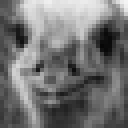
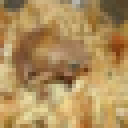
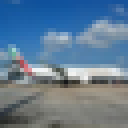
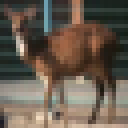
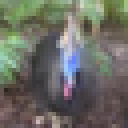
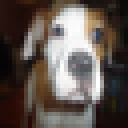
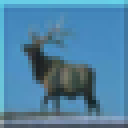
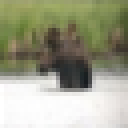
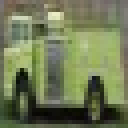
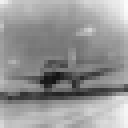

In [26]:
valset = valimgs(CIFAR10)
valimg = [getarray(valset[i].img) for i in 1:10000]
labels = onehotbatch([valset[i].ground_truth.class for i in 1:10000],1:10)
test = gpu.([(cat(valimg[i]..., dims = 4), labels[:,i]) for i in partition(1:10000, 1000)])
ids = rand(1:10000, 10)
image.(valset[ids])

In [27]:
rand_test = getarray.(image.(valset[ids]))
rand_test = cat(rand_test..., dims = 4) |> gpu
rand_truth = ground_truth.(valset[ids])
m(rand_test)


ErrorException: BatchNorm expected 16 channels, got 3

In [28]:
accuracy(test[1]...)


ErrorException: BatchNorm expected 16 channels, got 3

In [29]:
class_correct = zeros(10)
class_total = zeros(10)
for i in 1:10
  preds = m(test[i][1])
  lab = test[i][2]
  for j = 1:1000
    pred_class = findmax(preds[:, j])[2]
    actual_class = findmax(lab[:, j])[2]
    if pred_class == actual_class
      class_correct[pred_class] += 1
    end
    class_total[actual_class] += 1
  end
end

class_correct ./ class_total

ErrorException: BatchNorm expected 16 channels, got 3